In [1]:
from os.path import join
from math import isnan
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import RMSprop
from keras import Sequential
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Dense, Flatten


SEED = 222
save_dir = join("..", "beira", "outdata")

## References
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://stackoverflow.com/questions/55286115/tensorflow-keras-can-conv2d-layers-now-accept-multispectral-images-meaning-ba

# Non-spatial ML models
## Prepare data
1. No missing data (or assign zeros in areas of missing data)
2. Normalise features

In [111]:
# really coarse dealing with missing values
# TODO: replace elevation NaNs with GEBCO data
def load_featureset():
    feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp"))
    feature_gdf = feature_gdf.fillna(0.0)
    
    # temporal average winds
    wind_cols = ['w_14_00', 'w_14_06', 'w_14_12','w_14_18', 'w_15_00', 'w_15_06', 'w_15_12']
    feature_gdf["avg_wind"] = feature_gdf[wind_cols].mean(axis=1)
    feature_gdf = feature_gdf.drop(wind_cols, axis=1)
    
    feature_list = [*feature_gdf.columns]
    feature_list.remove("geometry")
    feature_list.remove("gebco")
    
    return feature_gdf, feature_list


In [114]:
# train test split
feature_gdf, feature_list = load_featureset()
feature_list.remove("floodfrac")

X, y = feature_gdf[feature_list], feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list).head()

X_train: (1354, 13)
X_test: (452, 13)
y_train: (1354,)
y_test: (452,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw,avg_wind
0,0.182087,0.500184,0.464051,0.252918,0.435585,0.000000,0.876208,0.793640,0.000776,0.738871,0.000000,0.000000,0.358969
1,0.029695,0.907777,0.460036,0.269458,0.225109,0.033615,0.029153,0.019766,0.660303,0.584336,0.000000,0.000000,0.978390
2,0.081462,0.771836,0.405434,0.521048,0.374320,0.252887,0.662901,0.424514,0.237534,0.580099,0.000000,0.000000,0.842803
3,0.074745,0.695984,0.424384,0.023785,0.407082,0.000000,0.866410,0.754976,0.000589,0.588757,0.241651,0.001065,0.467036
4,0.370472,0.563369,0.402542,0.385239,0.407092,0.000000,0.907139,0.623213,0.000000,0.738871,0.195283,0.006531,0.311205


## MLP parameters
Starting with [this tutorial](https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing).
#### Input
* **shape:** shape tuple, not including batch size, e.g. `shape=(12,)` means the input will be batches of 12-dimensional vectors. Elements can have value `None` which represent dimensions where shape isn't known.

#### Dense
* **units:** dimensionality of the output space
* **output:** n-d tensor with shape (batch_size, ..., units). E.g., for a 2D input with shape (batch_size, input_dim), the output would have shape (batch_size, units).

In [4]:
mlp = Sequential(name='FloodFraction_MLP')

mlp.add(Input(shape=(X_train.shape[1],)))  # (#features,)
mlp.add(Dense(64, activation="relu", name="Layer1"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(64, activation="relu", name="Layer2"))               # (batch_size, input_dim) -> (batch_size, 64)
mlp.add(Dense(1,  activation="relu", name="RegressionLayer"))      # (batch_size, input_dim) -> (batch_size, 1) [regression]
optimizer = RMSprop(0.001)
mlp.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

mlp.summary()

Model: "FloodFraction_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 64)                1280      
                                                                 
 Layer2 (Dense)              (None, 64)                4160      
                                                                 
 RegressionLayer (Dense)     (None, 1)                 65        
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


2022-05-09 09:28:04.353526: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
EPOCHS = 500
history = mlp.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0)

So the average error in the validation set looks to be around 0.1138 which is quite significant.


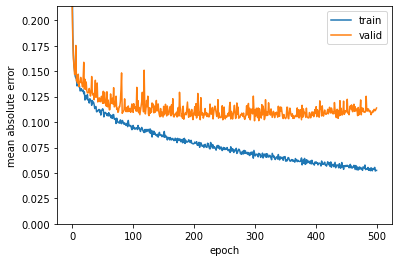

In [6]:
import numpy as np

def plot_history(history):
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('mean absolute error')
    plt.plot(history.epoch, np.array(history.history['mae']), 
           label='train')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'valid')
    plt.legend()
    plt.ylim([0, max(history.history['val_mae'])])

plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}"
      f" which is quite significant.")

In [7]:
[loss, mae] = mlp.evaluate(X_test, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absolute error: 0.11


In [8]:
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

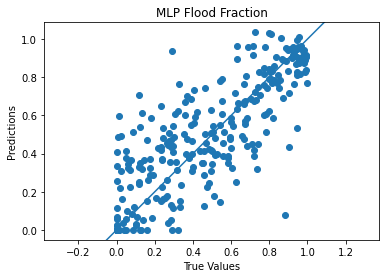

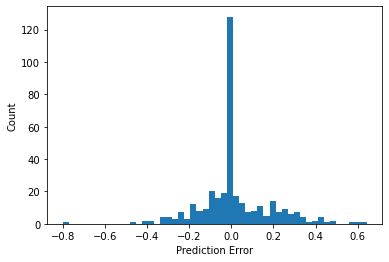

In [9]:
y_pred = mlp.predict(X_test).flatten()
plot_prediction(y_test, y_pred, title="MLP Flood Fraction")

### Conv1D Network
Requires input in the form `[batch_size, time_steps, input_dimension]` but currently data is in the form `[batch_size, features]`. So we pretty much convert the features into timesteps.

In [10]:
sample_size = X_train.shape[0]    # number of samples in train set
time_steps  = X_train.shape[1]    # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("Single sample shape:\n", X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

After reshape train data set shape:
 (1079, 19, 1)
Single sample shape:
 (19, 1)
An example sample:
 [[0.56590117]
 [0.42647509]
 [0.54679435]
 [0.4913605 ]
 [0.37390133]
 [0.        ]
 [0.90671482]
 [0.74739703]
 [0.7129182 ]
 [0.35759871]
 [0.0053544 ]
 [0.53956835]
 [0.1225737 ]
 [0.09195352]
 [0.08693411]
 [0.09786179]
 [0.38046887]
 [0.87519578]
 [0.888292  ]]


And so [batch_size, time_steps, input_dimension] -> [1151, 12, 1]. That is, each sample has 12 time steps with 1 input dimension. You can also think as each sample has 12 rows 1 column!

In [11]:
n_timesteps = X_train_reshaped.shape[1]  # 12
n_features  = X_train_reshaped.shape[2]  # 1 

# build model
conv1D = Sequential(name="FloodFraction_Conv1D")
conv1D.add(Input(shape=(n_timesteps,n_features)))

# add three convolutional layers with (64, 32, 16) filters
conv1D.add(Conv1D(filters=64, kernel_size=6, activation='relu', name="Conv1D_1"))
conv1D.add(Dropout(0.5))
conv1D.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
conv1D.add(Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))

# max-pooling layer
conv1D.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))

conv1D.add(Flatten())

# add some dense layers
conv1D.add(Dense(32, activation='relu', name="Dense_1"))
conv1D.add(Dense(n_features, name="Dense_2"))

optimizer = RMSprop(0.001)

conv1D.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
conv1D.summary()

Model: "FloodFraction_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 14, 64)            448       
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 11, 16)            1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 5, 16)            0         
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)       

In [12]:
# Store training stats
history = conv1D.fit(X_train_reshaped, y_train, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/500
27/27 [==============================] - 1s 7ms/step - loss: 0.1127 - mae: 0.2876 - val_loss: 0.0840 - val_mae: 0.2509
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0791 - mae: 0.2352 - val_loss: 0.0683 - val_mae: 0.2229
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0692 - mae: 0.2161 - val_loss: 0.0562 - val_mae: 0.2009
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0607 - mae: 0.2013 - val_loss: 0.0605 - val_mae: 0.2002
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0567 - mae: 0.1901 - val_loss: 0.0477 - val_mae: 0.1786
Epoch 6/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0545 - mae: 0.1871 - val_loss: 0.0500 - val_mae: 0.1745
Epoch 7/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0505 - mae: 0.1769 - val_loss: 0.0485 - val_mae: 0.1698
Epoch 8/500
27/27 [==============================] - 0s 4ms/step - loss: 0.0514 - m

Epoch 125/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0290 - mae: 0.1232 - val_loss: 0.0304 - val_mae: 0.1266
Epoch 126/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0273 - mae: 0.1191 - val_loss: 0.0332 - val_mae: 0.1324
Epoch 127/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0285 - mae: 0.1217 - val_loss: 0.0321 - val_mae: 0.1299
Epoch 128/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0273 - mae: 0.1208 - val_loss: 0.0323 - val_mae: 0.1323
Epoch 129/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0276 - mae: 0.1204 - val_loss: 0.0315 - val_mae: 0.1294
Epoch 130/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0276 - mae: 0.1223 - val_loss: 0.0359 - val_mae: 0.1345
Epoch 131/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0281 - mae: 0.1175 - val_loss: 0.0322 - val_mae: 0.1323
Epoch 132/500
27/27 [==============================] - 0s 4ms/step - 

Epoch 248/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0223 - mae: 0.1065 - val_loss: 0.0296 - val_mae: 0.1191
Epoch 249/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0211 - mae: 0.1020 - val_loss: 0.0274 - val_mae: 0.1180
Epoch 250/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0228 - mae: 0.1071 - val_loss: 0.0334 - val_mae: 0.1272
Epoch 251/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.1074 - val_loss: 0.0281 - val_mae: 0.1171
Epoch 252/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0210 - mae: 0.1043 - val_loss: 0.0275 - val_mae: 0.1161
Epoch 253/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0213 - mae: 0.1050 - val_loss: 0.0263 - val_mae: 0.1106
Epoch 254/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.1061 - val_loss: 0.0282 - val_mae: 0.1168
Epoch 255/500
27/27 [==============================] - 0s 3ms/step - 

Epoch 371/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0198 - mae: 0.1000 - val_loss: 0.0271 - val_mae: 0.1117
Epoch 372/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0178 - mae: 0.0940 - val_loss: 0.0254 - val_mae: 0.1102
Epoch 373/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0185 - mae: 0.0956 - val_loss: 0.0276 - val_mae: 0.1166
Epoch 374/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0184 - mae: 0.0967 - val_loss: 0.0256 - val_mae: 0.1097
Epoch 375/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0189 - mae: 0.0979 - val_loss: 0.0281 - val_mae: 0.1152
Epoch 376/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0186 - mae: 0.0973 - val_loss: 0.0274 - val_mae: 0.1157
Epoch 377/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0180 - mae: 0.0970 - val_loss: 0.0252 - val_mae: 0.1101
Epoch 378/500
27/27 [==============================] - 0s 3ms/step - 

Epoch 494/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0153 - mae: 0.0894 - val_loss: 0.0262 - val_mae: 0.1160
Epoch 495/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0165 - mae: 0.0931 - val_loss: 0.0266 - val_mae: 0.1155
Epoch 496/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0158 - mae: 0.0904 - val_loss: 0.0246 - val_mae: 0.1080
Epoch 497/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0154 - mae: 0.0881 - val_loss: 0.0268 - val_mae: 0.1145
Epoch 498/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0162 - mae: 0.0898 - val_loss: 0.0265 - val_mae: 0.1123
Epoch 499/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0159 - mae: 0.0898 - val_loss: 0.0268 - val_mae: 0.1124
Epoch 500/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0152 - mae: 0.0881 - val_loss: 0.0283 - val_mae: 0.1190


So the average error in the validation set looks to be around 0.1249


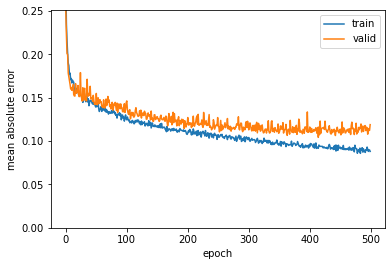

In [13]:
plot_history(history)

print(f"So the average error in the validation set looks to be around {np.round(np.mean(history.history['val_mae']), 4)}")

In [14]:
[loss, mae] = conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set mean absolute error: {:4.2f}".format(mae))

Testing set mean absolute error: 0.12


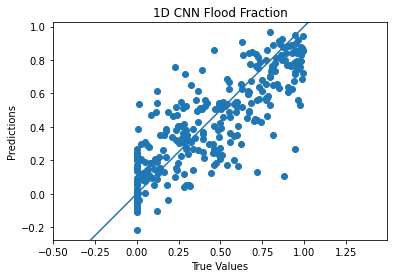

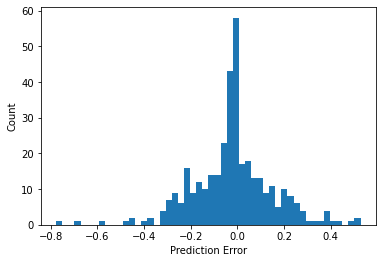

In [15]:
y_pred = conv1D.predict(X_test_reshaped).flatten()
plot_prediction(y_test, y_pred, title="1D CNN Flood Fraction")

## 2D Convolutional Neural Network
To create training, validation, and test sets, pixel locality must be preserved. For now, take the top of the image  as the training set, and split the bottom half into training and test sets. This isn't ideal and hopefully I can find a better approach.

## Aspatial and spatial random forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [17]:
feature_gdf = gpd.read_file(join(save_dir, "feature_stats.shp")).dropna()
feature_gdf["lon"] = feature_gdf.geometry.centroid.x
feature_gdf["lat"] = feature_gdf.geometry.centroid.y
feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")
feature_list.remove("geometry")

feature_list_aspatial = feature_list[:-2]
feature_list_spatial = feature_list

/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_1421/351396300.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feature_gdf["lon"] = feature_gdf.geometry.centroid.x
/var/folders/pw/g3l12fr515df7s6dpdch4qx00000gn/T/ipykernel_1421/351396300.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feature_gdf["lat"] = feature_gdf.geometry.centroid.y


### Aspatial random forest

In [18]:
X, y = feature_gdf[feature_list_aspatial], feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
#nscaler = MinMaxScaler(feature_range=(0, 1))
#nscaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list_aspatial).head()

X_train: (1079, 12)
X_test: (360, 12)
y_train: (1079,)
y_test: (360,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw
171,38.372424,137.089179,5.799287e+06,2357.023282,4.324787,0.0,7955.210213,6103.952979,0.000000,0.018408,4403.505082,0.008714
444,7.972485,122.228718,-6.846549e+06,412.854979,2.000000,0.0,6740.650532,5574.772234,0.002872,0.010459,895.596702,0.008902
1003,4.502319,157.703114,-1.123548e+06,102.639805,3.827021,0.0,7501.119894,6472.119043,0.005745,0.014668,7094.854998,0.000635
833,5.899434,158.981833,7.972362e+06,596.736503,2.264894,0.0,7164.381489,5915.908723,0.210319,0.014668,2623.626267,0.002249
639,4.634448,103.730700,-1.174498e+06,57.340908,2.476421,0.0,7425.244574,6720.132128,0.000000,0.014558,4566.829192,0.001015


mean absolute error: 0.12243740183046674


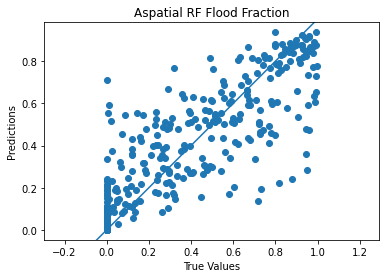

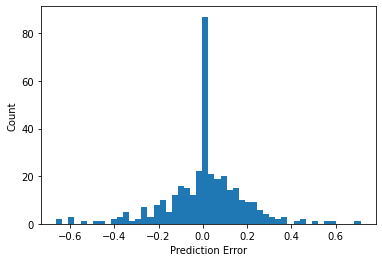

In [19]:
regr = RandomForestRegressor(random_state=SEED)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(f"mean absolute error: {mean_absolute_error(y_test, y_pred)}")
plot_prediction(y_test, y_pred, title="Aspatial RF Flood Fraction")

In [27]:
def viz_results(feature_gdf, y_pred, X_test, X_train, algorithm):
    X_test_df = feature_gdf.filter(X_test.index, axis=0)
    X_train_df = feature_gdf.filter(X_train.index, axis=0)
    X_test_df["pred"] = y_pred
    X_test_df["pred_diff"] = y_pred - X_test_df.floodfrac

    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    feature_gdf.plot(ax=ax[0], column="floodfrac", cmap="binary_r", alpha=0.6, legend=True)
    X_test_df.boundary.plot(ax=ax[0], color='red')
    ax[0].set_title("train/test-split")

    feature_gdf.plot(ax=ax[1], column="floodfrac", cmap="binary_r", alpha=0.6)
    X_test_df.plot(ax=ax[1], column="pred", cmap='GnBu', legend=True)
    ax[1].set_title(f"{algorithm}\npredicted flood fraction")

    feature_gdf.plot(ax=ax[2], column="floodfrac", cmap="binary_r", alpha=0.6)
    X_test_df.plot(ax=ax[2], column="pred_diff", cmap='Spectral_r', legend=True, vmin=-0.4, vmax=0.4)
    ax[2].set_title(f"{algorithm}\nprediction - observed");


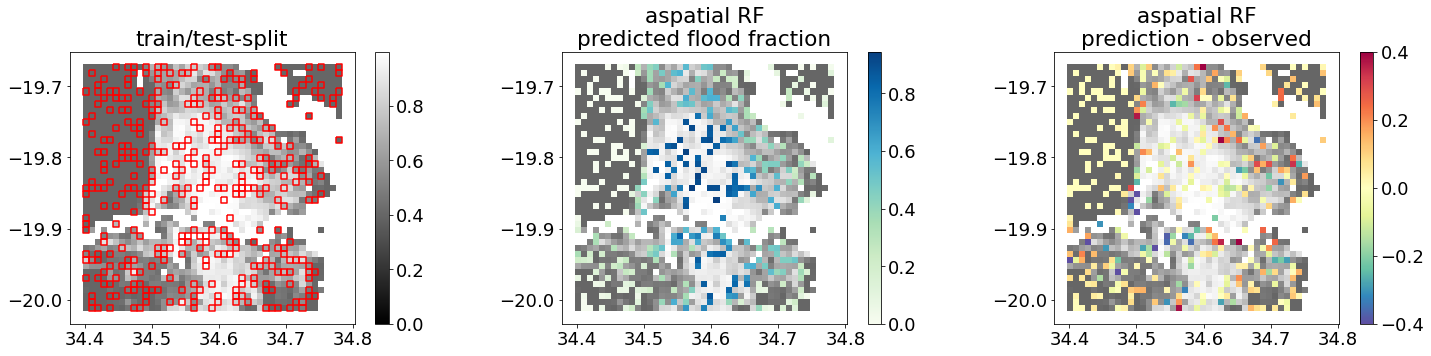

In [28]:
viz_results(feature_gdf, y_pred, X_test, X_train, "aspatial RF")

## Spatial random forest

In [22]:
X, y = feature_gdf[feature_list_spatial], feature_gdf["floodfrac"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# scale input features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# tutorial has one-hot encoded categorical data we have not
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_train: {y_train.shape}\ny_test: {y_test.shape}")

pd.DataFrame(X_train, columns=feature_list_spatial).head()

X_train: (1079, 14)
X_test: (360, 14)
y_train: (1079,)
y_test: (360,)


,elevation,aspect,curvature,slope,soilcarbon,mangroves,ndvi_mfmas,evi_mfmask,jrc_permwa,precipitat,dist_pw,slope_pw,lon,lat
171,38.372424,137.089179,5.799287e+06,2357.023282,4.324787,0.0,7955.210213,6103.952979,0.000000,0.018408,4403.505082,0.008714,34.437244,-19.699098
444,7.972485,122.228718,-6.846549e+06,412.854979,2.000000,0.0,6740.650532,5574.772234,0.002872,0.010459,895.596702,0.008902,34.491143,-19.876605
1003,4.502319,157.703114,-1.123548e+06,102.639805,3.827021,0.0,7501.119894,6472.119043,0.005745,0.014668,7094.854998,0.000635,34.607924,-19.986391
833,5.899434,158.981833,7.972362e+06,596.736503,2.264894,0.0,7164.381489,5915.908723,0.210319,0.014668,2623.626267,0.002249,34.571992,-19.969506
639,4.634448,103.730700,-1.174498e+06,57.340908,2.476421,0.0,7425.244574,6720.132128,0.000000,0.014558,4566.829192,0.001015,34.536059,-19.749835


mean absolute error: 0.10363592955716487


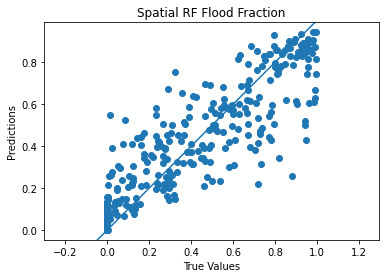

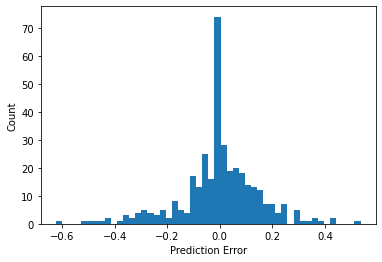

In [23]:
regr = RandomForestRegressor(random_state=SEED)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(f"mean absolute error: {mean_absolute_error(y_test, y_pred)}")
plot_prediction(y_test, y_pred, title="Spatial RF Flood Fraction")

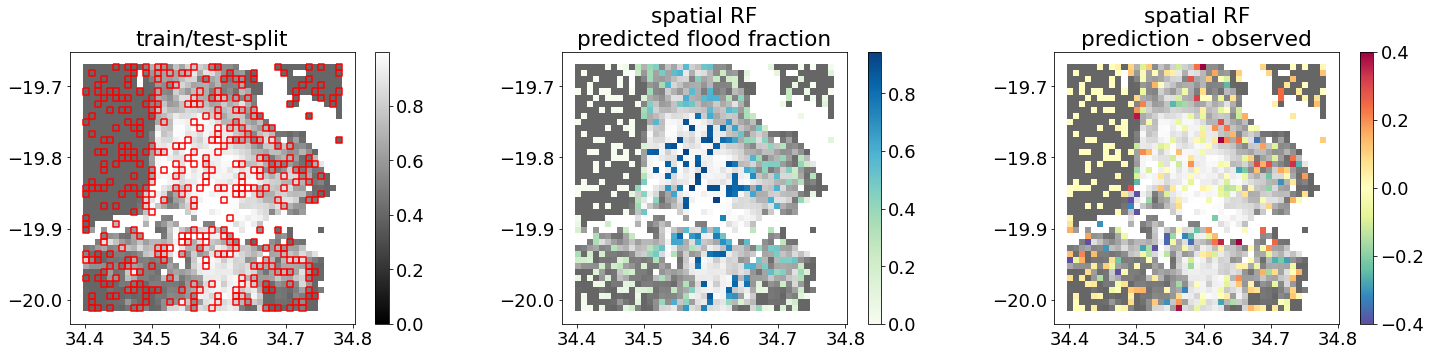

In [29]:
viz_results(feature_gdf, y_pred, X_test, X_train, "spatial RF")